In [1]:
# Marcus Pearce
# FairFace Model Training

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import matplotlib.image as img
from sklearn.model_selection import train_test_split

import torchvision.models as models

# from PIL import Image      # PIL = Python Imaging Library



In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load data w/ correct file path : 
  # NOTE:  different paths for Jupyter and Google Colab

# Google Colab: 
# train_labels = pd.read_csv("/content/drive/My Drive/UCLA Drive/AI Projects/MP_FairFace/fairface_label_train.csv")
# test_labels = pd.read_csv("/content/drive/My Drive/UCLA Drive/AI Projects/MP_FairFace/fairface_label_val.csv")

# train_labels = pd.read_csv("/content/drive/My Drive/UCLA Drive/AI Projects/MP_FairFace/fairface_label_val.csv")
# test_labels = pd.read_csv("/content/drive/My Drive/UCLA Drive/AI Projects/MP_FairFace/fairface_label_val.csv")

data_path = '/content/drive/My Drive/UCLA Drive/AI Projects/MP_FairFace/'

# Jupyter Notebook:
train_labels = pd.read_csv(r'./fairface-img-margin025-trainval/fairface_label_train.csv')
test_labels = pd.read_csv(r'./fairface-img-margin025-trainval/fairface_label_val.csv')
data_path = r'./fairface-img-margin025-trainval/'


In [3]:
# sample look at parsed csv data
train_labels.head()
# test_labels.tail()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [4]:
# sample seeing distribution of given categories (e.g. race)
train_labels['race'].value_counts()

White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: race, dtype: int64

asdf
asdf
asdf
asdf
asdf
asdf
asdf


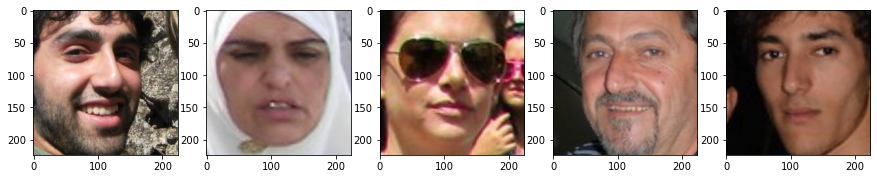

In [5]:
# Debug outputs

# categories (found/used in csvs)
age_list = ['3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_list = ['Male', 'Female']
race_list = ['White', 'Black', 'Latino_Hispanic', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern']


# Debugging Output

fig,ax = plt.subplots(1,5,figsize = (15,3))

# for each race, process images
for race in race_list:
    print("asdf")
    for i,idx in enumerate(train_labels[train_labels['race'] == race]['file'][-5:]):
        path = os.path.join(data_path,idx)
        ax[i].imshow(img.imread(path))

In [6]:
# dict to map given label to a number
dict_race_to_number = {'White' : 0, 
                       'Black': 1, 
                       'Latino_Hispanic': 2, 
                       'East Asian' : 3, 
                       'Southeast Asian' : 4, 
                       'Indian' : 5, 
                       'Middle Eastern' : 6}

In [6]:
class FairFaceDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
#         img_name,label = self.data[index]
        img_name = self.data[index][0]
#         label = self.data[index][3]     # index 3 for race, need as tensor
#         label = torch.tensor(self.data[index][3])   # index 3 for race, need as tensor
        label = dict_race_to_number[self.data[index][3]]   # index 3 for race, need as tensor -> convert to number from str first
        label = torch.tensor(label)
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        
#         output = {'image': image, 'label': label}
        if self.transform is not None:
            image = self.transform(image)
#             output['image'] = self.transform(output['image'])
        return image, label
#         return output


In [7]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [8]:
# make data tensors

train_transform = transforms.Compose([transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToTensor()])

valid_transform = transforms.Compose([transforms.ToTensor()])

# valid_transform = transforms.Compose([transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
# Hyperparameter values

num_epochs = 30
num_classes = 7  # for race
batch_size = 25
learning_rate = 0.0001

In [11]:
# create train/val/test data split, and create Datasets and DataLoaders

train_split, val_split = train_test_split(train_labels, stratify=train_labels.gender, test_size=0.2)

train_data = FairFaceDataset(train_split, data_path, train_transform )
valid_data = FairFaceDataset(val_split, data_path, valid_transform )
test_data = FairFaceDataset(test_labels, data_path, test_transform )

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

print(train_split)

                  file    age  gender             race  service_test
75533  train/75534.jpg  10-19    Male  Latino_Hispanic         False
81750  train/81751.jpg    3-9    Male       East Asian         False
26679  train/26680.jpg    0-2    Male           Indian         False
4311    train/4312.jpg  20-29  Female            White         False
41380  train/41381.jpg  20-29    Male  Latino_Hispanic          True
...                ...    ...     ...              ...           ...
24792  train/24793.jpg  20-29    Male            White         False
39896  train/39897.jpg  30-39    Male       East Asian         False
10446  train/10447.jpg  40-49    Male            White         False
77470  train/77471.jpg  50-59    Male            Black         False
51967  train/51968.jpg  30-39  Female   Middle Eastern          True

[69395 rows x 5 columns]


In [12]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
# Debugging output

# print(len(train_data))

# for i in range(3):
#     print(train_data[i])

# trainimages, trainlabels = next(iter(train_loader))

# fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
# print('training images')
# for i in range(5):
#     axe1 = axes[i] 
#     print(trainimages[i])
#     imshow(trainimages[i], ax=axe1, normalize=False)



In [14]:
# Use model architecture from paper:
    # torchvision.models ResNet-34(pretrained=False)
    # Criterion torch.nn.CrossEntropyLoss
    # Optimizer torch.optim.Adam

model = models.resnet34(pretrained=False).to(device)
# print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Actual training of model

train_losses = []
valid_losses = []

print("Training model...")

for epoch in range(1, num_epochs+1):
    # keep track of train/val loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training the model
    model.train()
    for data, target in train_loader:
                
        optimizer.zero_grad()                   # init gradients to zeros
        output = model(data)                    # forward pass
#         print(output)
#         print(target)
        loss = criterion(output, target)        # compute loss
        loss.backward()                         # loss backwards
        optimizer.step()                        # update model params
        
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
        
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Training model...


NameError: name 'dict_race_to_number' is not defined